# Team Benchmark

**Authors:** Marissa Nicole Esteban, Gabe Krishnadasan, Diana Montoya-Herrera, Gabe Seidl, Madeleine Woo

**Date:** 10/5/2023

### Wave Height

#### Dataset: https://www.kaggle.com/code/shaltaf/the-prediction-of-significant-wave-height-hs/notebook 

## Table of Contents:
* [Data Importing and Pre-processing](#data-importing)
* [Data Analysis and Visualization](#data-vis)
* [Data Analytics](#data-analytics)

## Data Importing and Pre-processing <a class="anchor" id="data-importing"></a>

In [1]:
# import libraries needed
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
# read in file
wave_df = pd.read_csv('Coastal Data System - Waves (Mooloolaba) 01-2017 to 06 - 2019.csv')

In [3]:
# num rows and columns
wave_df.shape

(43728, 7)

In [4]:
# num of categorical variables
cat_count = 0
for dtype in wave_df.dtypes:
    if dtype == 'object':
        cat_count = cat_count + 1

In [5]:
print('# of categorical variables:',cat_count)
print('# of continuous variables:',wave_df.shape[1] - cat_count - 1) # subtract and extra column as 1 column is an ID column

# of categorical variables: 1
# of continuous variables: 5


In [6]:
wave_df.head()

,Date/Time,Hs,Hmax,Tz,Tp,Peak Direction,SST
0,01/01/2017 00:00,-99.900,-99.90,-99.900,-99.900,-99.9,-99.90
1,01/01/2017 00:30,0.875,1.39,4.421,4.506,-99.9,-99.90
2,01/01/2017 01:00,0.763,1.15,4.520,5.513,49.0,25.65
3,01/01/2017 01:30,0.770,1.41,4.582,5.647,75.0,25.50
4,01/01/2017 02:00,0.747,1.16,4.515,5.083,91.0,25.45


### Handling missing data

In [32]:
# missing data
total = wave_df.isnull().sum().sort_values(ascending=False)
percent = (wave_df.isnull().sum()/wave_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

wave_df=wave_df.replace(-99.9,np.nan)
wave_df=wave_df.interpolate(limit_direction='both')

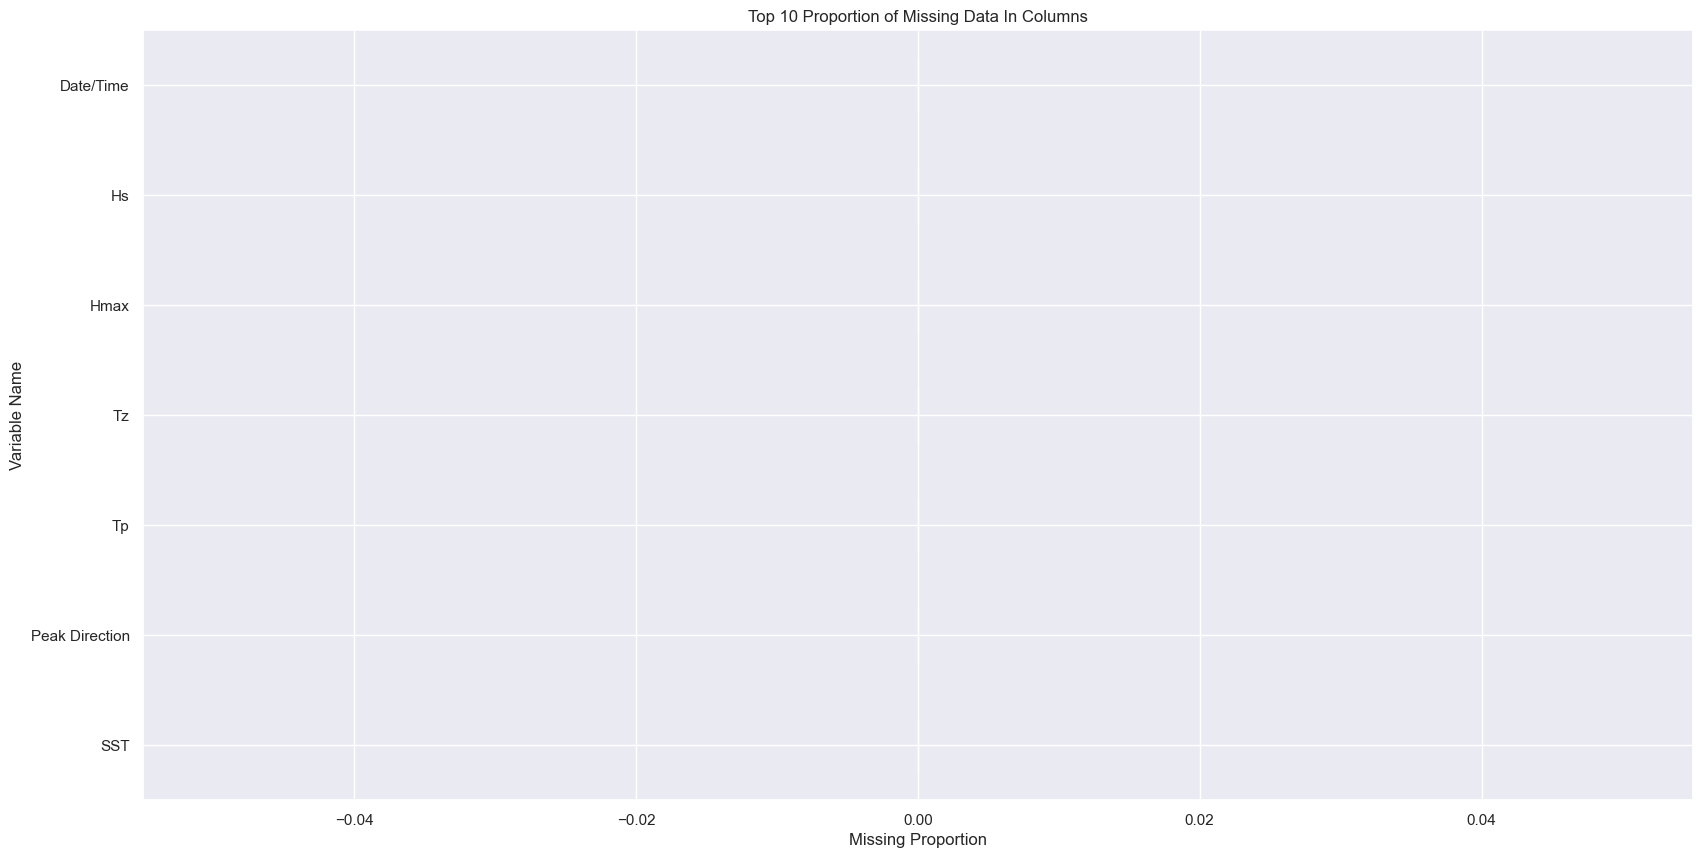

In [33]:
missing_data['Percent'].head(10).plot(kind='barh', figsize = (20,10)).invert_yaxis() # top 10 missing columns
plt.xlabel("Missing Proportion")
plt.ylabel("Variable Name")
plt.title("Top 10 Proportion of Missing Data In Columns")
plt.show()

In [34]:
# TODO later:
# handle missing data

### Handling Outliers

#### Target Variable

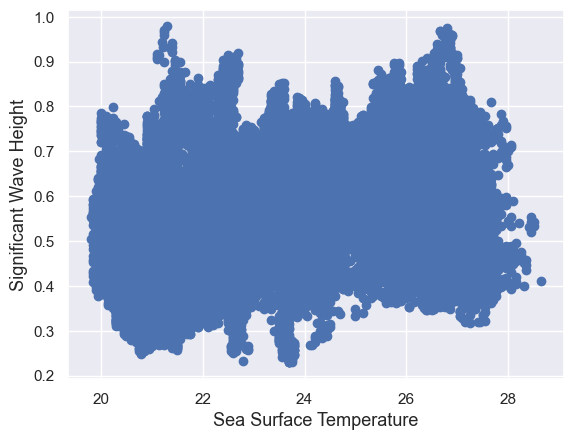

In [35]:
fig, ax = plt.subplots()
ax.scatter(x = wave_df['SST'], y = wave_df['Hs'])
plt.ylabel('Significant Wave Height', fontsize=13)
plt.xlabel('Sea Surface Temperature', fontsize=13)
plt.show()

### Normalize Target Variable


 mu = 0.57 and sigma = 0.12



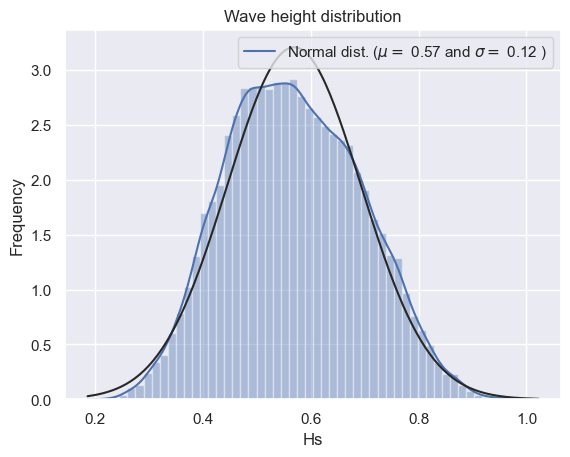

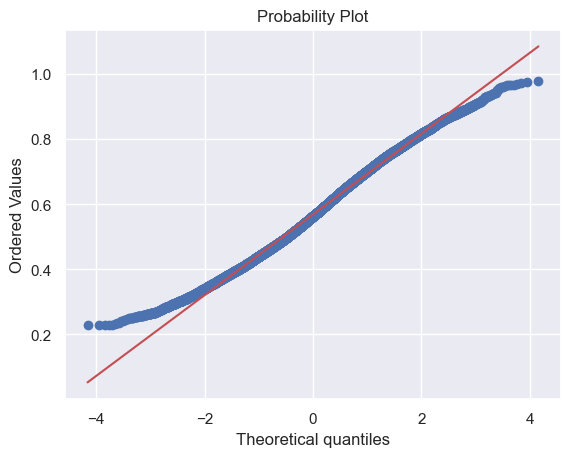

In [36]:
sns.distplot(wave_df['Hs'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(wave_df['Hs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
# TODO test with different distributions
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(wave_df['Hs'], plot=plt)
plt.show()

In [37]:
# Identify non finite values
non_finite_values = wave_df['Hs'][~np.isfinite(wave_df['Hs'])]
print(non_finite_values)

Series([], Name: Hs, dtype: float64)


In [38]:
# Remove non finite values

wave_df = wave_df[np.isfinite(wave_df['Hs'])]


 mu = 0.45 and sigma = 0.08



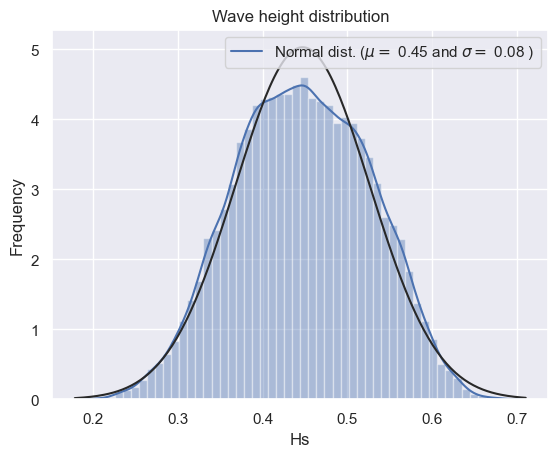

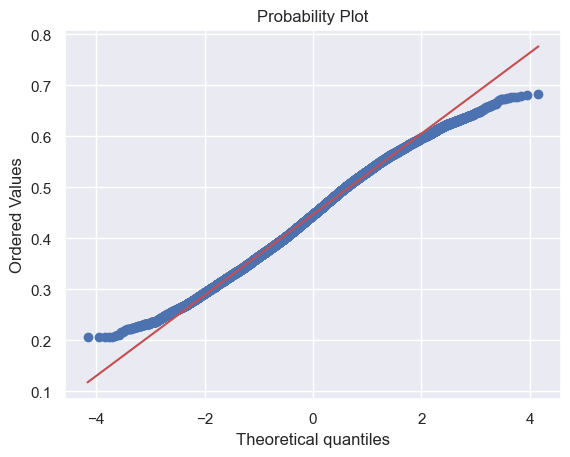

In [39]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
wave_df["Hs"] = np.log1p(wave_df["Hs"])

# Check the new distribution 
sns.distplot(wave_df['Hs'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(wave_df['Hs'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Wave height distribution')

# Get also the QQ-plot
fig = plt.figure()
res = probplot(wave_df['Hs'], plot=plt)
plt.show()

## Data Analysis and Visualization <a class="anchor" id="data-vis"></a>

In [40]:
from sklearn.preprocessing import LabelEncoder

Target Variable Scatterplots

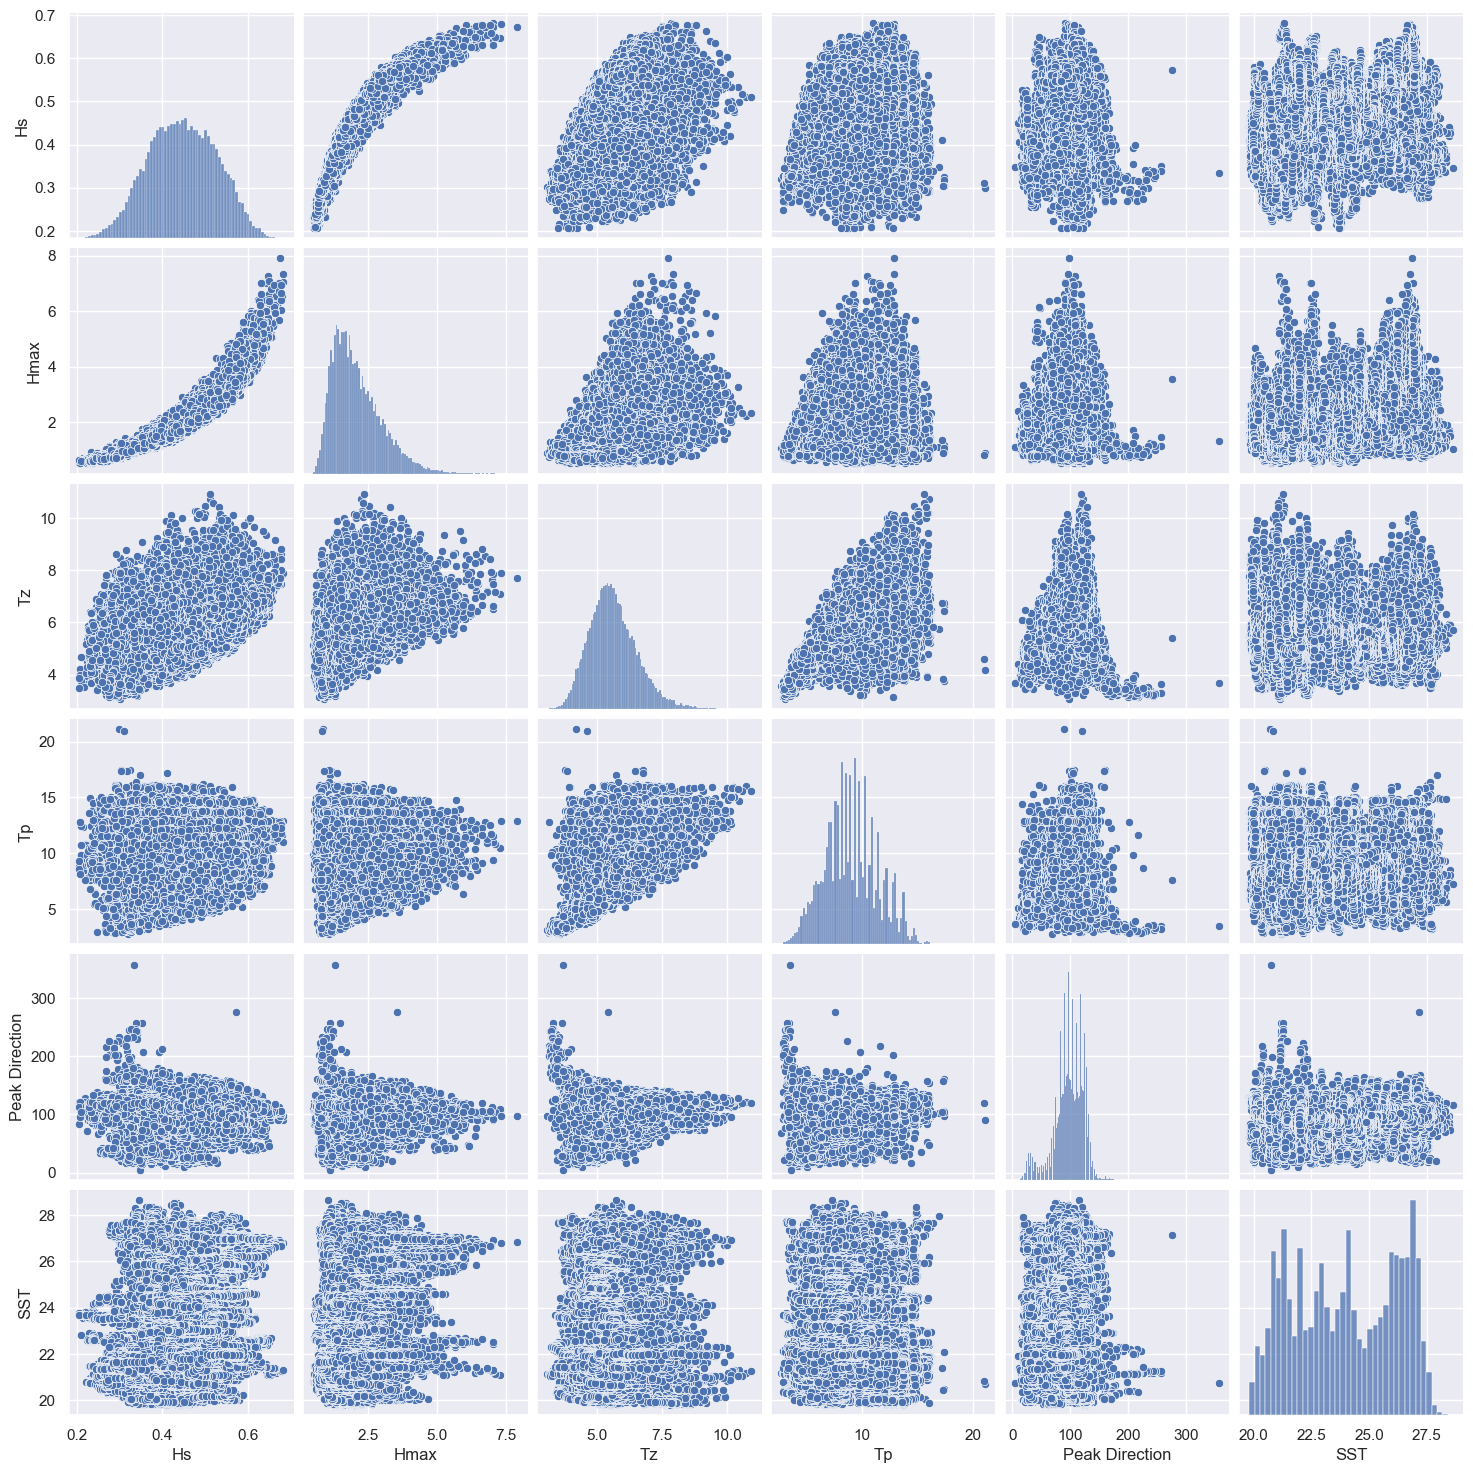

In [41]:
# scatterplot
sns.set()
cols = ['Date/Time','Hs','Hmax','Tz','Tp','Peak Direction','SST']
sns.pairplot(wave_df[cols], size = 2.5)
plt.show();

Correlation Matrix

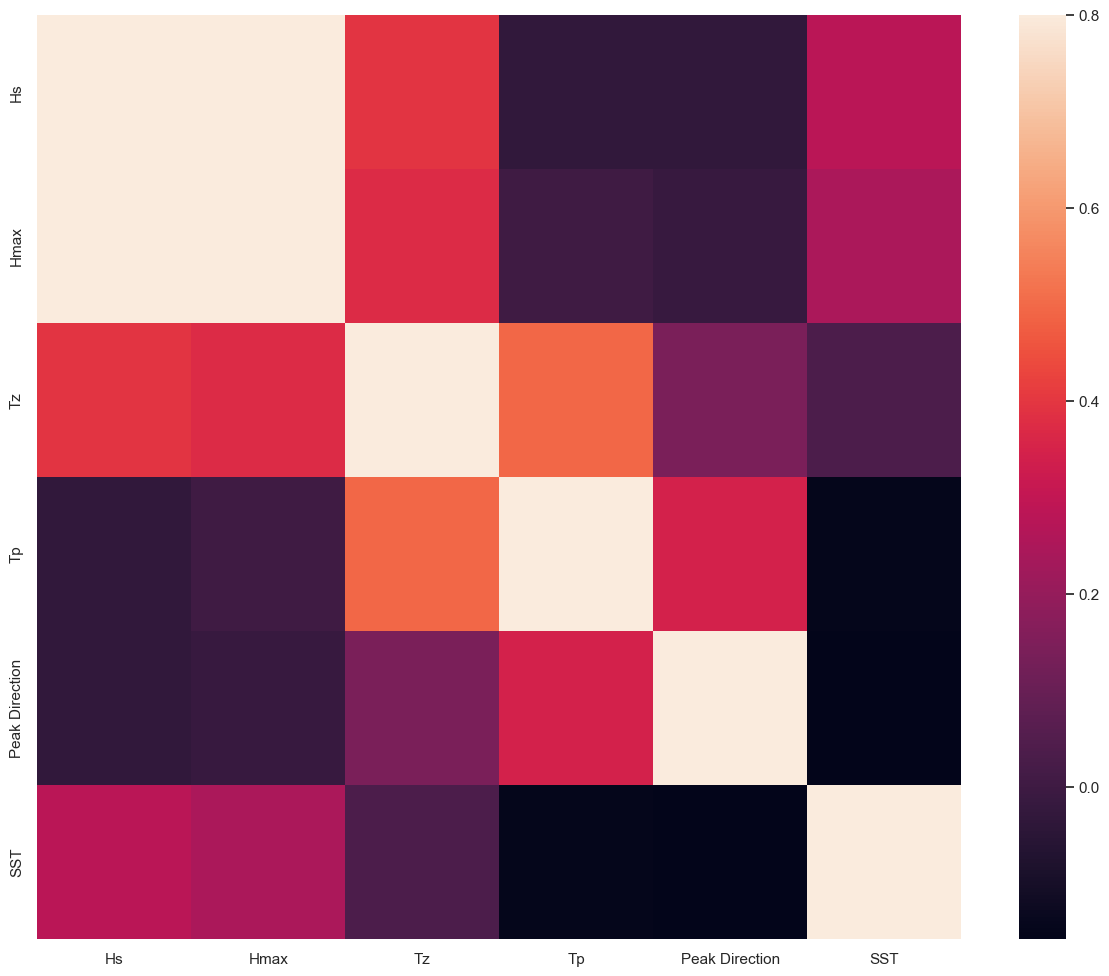

In [42]:
# Correlation map to see how features are correlated with SalePrice
corrmat = wave_df.corr()
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

In [43]:
# TODO: Here, we would change continuous variables to categorical variables if needed.
# For this example, we don't need to do this.

#### Label encode categorical variables

In [44]:
# We only have one categorical variable, so we won't be doing this step at this point

## Data Analytics <a class="anchor" id="data-analytics"></a>

In [45]:
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

In [46]:
# return a list containing all the column names in wave_df except for 'Hs'.
# aka isolating our dependent variable: avg wave height. 
train_df = wave_df[wave_df.columns.difference(['Hs'])]
train_df.head()

,Date/Time,Hmax,Peak Direction,SST,Tp,Tz
1,01/01/2017 00:30,1.39,49.0,25.65,4.506,4.421
2,01/01/2017 01:00,1.15,49.0,25.65,5.513,4.520
3,01/01/2017 01:30,1.41,75.0,25.50,5.647,4.582
4,01/01/2017 02:00,1.16,91.0,25.45,5.083,4.515
5,01/01/2017 02:30,1.61,68.0,25.45,6.181,4.614


In [47]:
# Validation function
n_folds = 5

def rmse_cv(model,n_folds):
    kf=KFold(n_splits=n_folds)
    rmse = np.sqrt(-cross_val_score(model, train_df, wave_df.Hs, scoring="neg_mean_squared_error", cv = kf))
    return rmse

In [48]:
lr_w_int = LinearRegression()
lr_no_int = LinearRegression(fit_intercept=False)

In [49]:
neigh = KNeighborsRegressor(n_neighbors=10)

In [50]:
rf = RandomForestRegressor(n_estimators=100)

In [51]:
dt = DecisionTreeRegressor(max_depth = 10)

In [52]:
model_xgb = xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.01)

In [53]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.01, max_depth=5, n_estimators=1000)

#### Algorithm Results on a 5 Fold Cross Validation

In [54]:
score_linear = rmse_cv(lr_w_int,n_folds)
print("Linear Regression (w/ Intercept) score: {:.4f} ({:.4f})\n".format(score_linear.mean(), score_linear.std()))

Linear Regression (w/ Intercept) score: nan (nan)



In [55]:
score_linear_no_int = rmse_cv(lr_no_int,n_folds)
print("Linear Regression (No Intercept) score: {:.4f} ({:.4f})\n".format(score_linear_no_int.mean(), score_linear_no_int.std()))

Linear Regression (No Intercept) score: nan (nan)



In [56]:
score_neigh = rmse_cv(neigh,n_folds)
print("Nearest Neighbor (13) score: {:.4f} ({:.4f})\n".format(score_neigh.mean(), score_neigh.std()))

Nearest Neighbor (13) score: nan (nan)



In [57]:
score_dt = rmse_cv(dt,n_folds)
print("Decision Tree Regression score: {:.4f} ({:.4f})\n".format(score_dt.mean(), score_dt.std()))

Decision Tree Regression score: nan (nan)



In [58]:
score_rf = rmse_cv(rf,n_folds)
print("Random Forest Regression score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Random Forest Regression score: nan (nan)



In [59]:
score_xg = rmse_cv(model_xgb,n_folds)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score_xg.mean(), score_xg.std()))

Xgboost score: nan (nan)



In [60]:
score_lgbm = rmse_cv(model_lgb,n_folds)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score_lgbm.mean(), score_lgbm.std()))

LGBM score: nan (nan)



In [61]:
# plot RMSE and STD for each Algorithm
data = {'Linear (No Intercept)':[score_linear_no_int.mean(),score_linear_no_int.std()], 'XGBoost':[score_xg.mean(),score_xg.std()], 'Random Forest': [score_rf.mean(),score_rf.std()]
        , 'LightGBM': [score_lgbm.mean(),score_lgbm.std()], 'Decision Tree': [score_dt.mean(),score_dt.std()],'Nearest Neighbor': [score_neigh.mean(),score_neigh.std()]}
data_df = pd.DataFrame(data=data).T.reset_index().sort_values(by = [0],ascending = True)
data_df.columns = ['Algorithm','RMSE','STD']

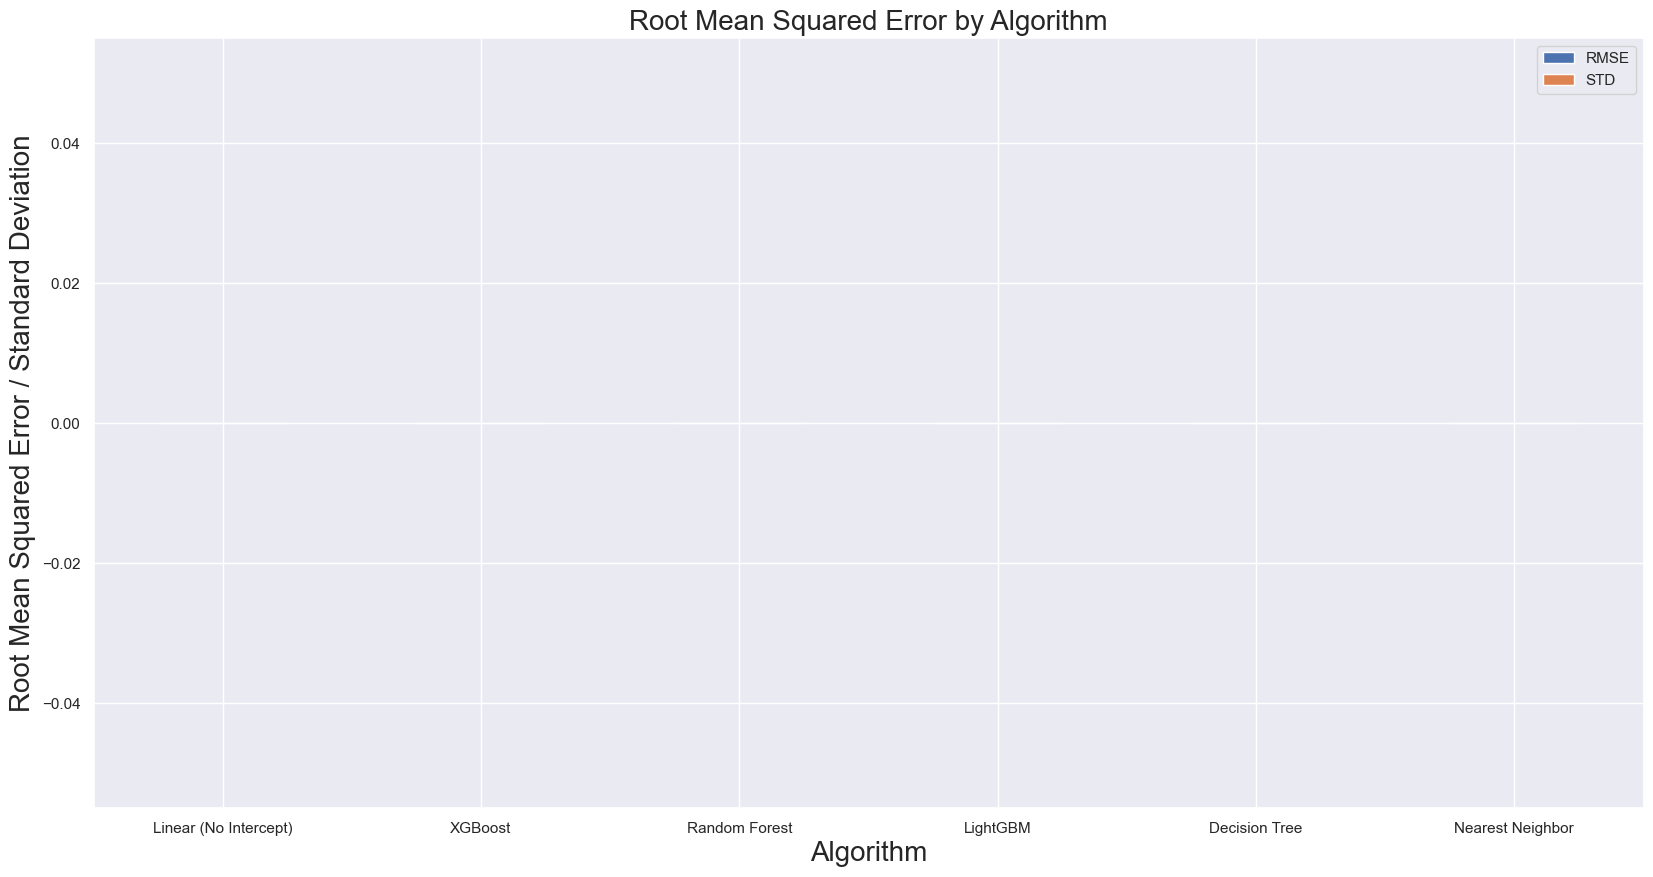

In [62]:
# creating the bar plot
data_df.plot(kind='bar',x = 'Algorithm', y = ['RMSE', 'STD'], figsize = (20,10), rot=0)
plt.xlabel("Algorithm",fontsize=20)
plt.ylabel("Root Mean Squared Error / Standard Deviation",fontsize=20)
plt.title("Root Mean Squared Error by Algorithm",fontsize=20)
plt.show()

In [63]:
model = model_xgb.fit(train_df, wave_df.Hs) #fit model on entire dataset to get variable importance since we fit it on each fold
feature_important = model.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data[:20].plot(kind='barh', figsize = (20,10)).invert_yaxis(); ## plot top 20 features
plt.xlabel("Feature Importance",fontsize=20)
plt.ylabel("Feature Name",fontsize=20)
plt.title("Feature Importance Plot",fontsize=20)
plt.show()

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Date/Time: object